In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [4]:
stocks = pd.read_csv("../input/nyse/prices.csv", parse_dates=['date'])
stocks = stocks[stocks['symbol'] == "GOOG"].set_index('date')
stocks.tail()

FileNotFoundError: [Errno 2] No such file or directory: '../input/nyse/prices.csv'

### Correct for split

Simple multiply by two, which is fine for our purposes here 

In [451]:
split_date = datetime(2014, 3, 27)
stocks.loc[(stocks.index >= split_date), ['open', 'close', 'low', 'high', 'volume']] = stocks[(stocks.index >= start_date)][['open', 'close', 'low', 'high', 'volume']] * 2

In [2]:
plt.figure(figsize=(20, 10))
plt.plot(stocks.close, label="close")
#plt.plot(stocks_slice.close, label="close")
plt.grid()
plt.legend()

NameError: name 'plt' is not defined

### Chart patterns

There are 3 types of patterns, depending on how price is likely to behave after completion: 
* *reversal patterns*, where price is likely to reverse, 
* *continuation patterns*, where price is likely to continue its course and 
* *bilateral patterns*, where price can go either way, depending on whether it breaks to the upside or to the downside.

The measurements of the chart pattern can be used to project the next price movement and what target to aim for. These patterns can either be traded aggressively (with less conformation) or conservatively (with more conformation) so the rules of entry and exit can vary. It's easy to calculate the reward / risk for them, which is important to know before entering a trade.

_source: https://www.tradingview.com/ideas/chartpattern/_

#### MACD

In [453]:
def get_macd(s, period_short=12, period_long=26, period_signal=9):
    ema_short = s.ewm(span=period_short).mean()
    ema_long = s.ewm(span=period_long).mean()
    macd = ema_short - ema_long
    signal = macd.ewm(span=period_signal).mean()
    return ema_short, ema_long, macd, signal

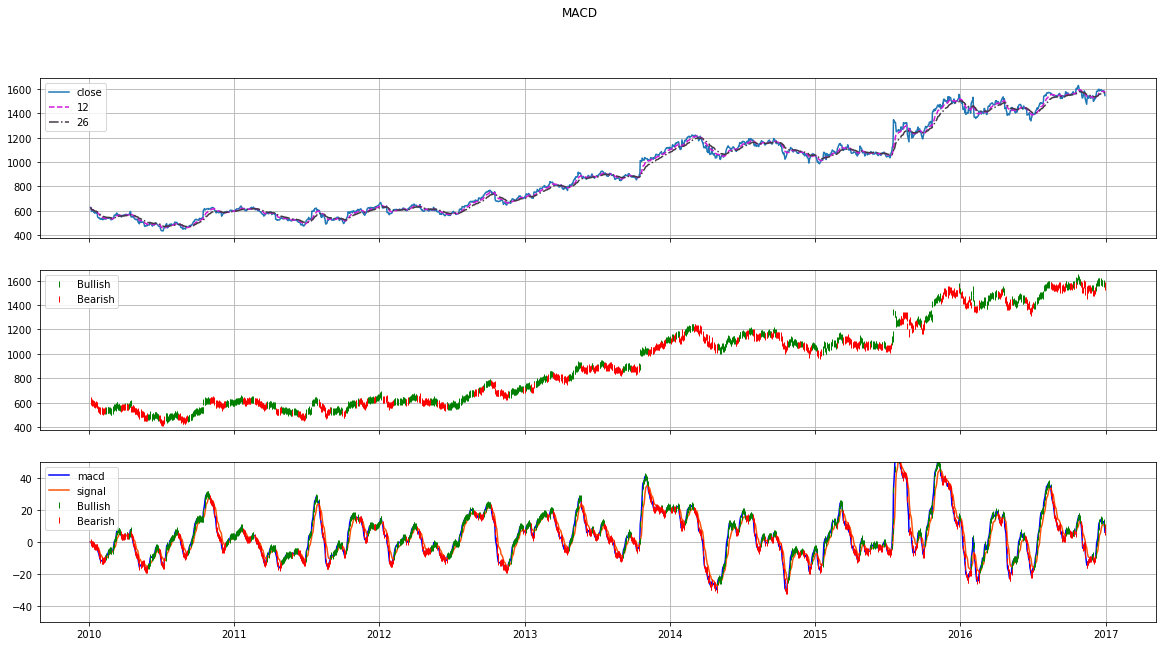

In [454]:
ema_short, ema_long, macd, signal = get_macd(stocks.close)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)

plt.suptitle("MACD")
axs[0].grid()
axs[0].plot(stocks.close, label="close")
axs[0].plot(ema_short, label="12", color="#CF19D8", linestyle="--")
axs[0].plot(ema_long, label="26", color="#433846", linestyle="-.")
axs[0].legend()

axs[1].plot(stocks.close[macd>signal], label="Bullish", color="green", linestyle="None", marker="|")
axs[1].plot(stocks.close[macd<signal], label="Bearish", color="red", linestyle="None", marker="|")
axs[1].grid()
axs[1].legend()

axs[2].plot(macd, label="macd", color="blue")
axs[2].plot(signal, label="signal", color="#FC5207")
axs[2].plot(macd[macd>signal], label="Bullish", color="green", linestyle="None", marker="|")
axs[2].plot(macd[macd<signal], label="Bearish", color="red", linestyle="None", marker="|")
axs[2].grid()
axs[2].legend()
axs[2].set_ylim(-50, 50)

plt.show()

### AB = CD pattern

In [455]:
def get_fibonacci_level(low, high, value):
    diff = high - low
    return high - value * diff

In [456]:
def get_fibonacci_levels(low, high):
    fib_values = [0.382, 0.618, 0.786, -0.272, -0.618]
    diff = high - low
    
    levels = {}
    for v in fib_values:
        levels[f"{v}"] = (high - v * diff)
    return levels

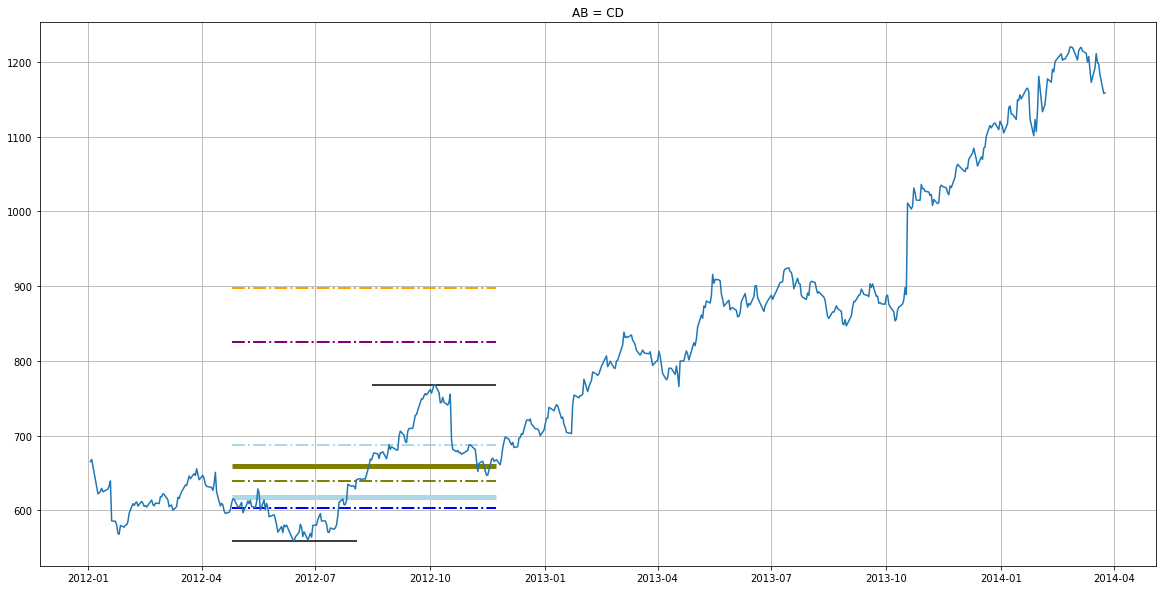

In [457]:
start_date = datetime(2012, 1, 1)
end_date = datetime(2012, 11, 1)

stocks_slice = stocks[(stocks.index >= start_date) & (stocks.index < end_date)]

# get low and high values for this period
low_date = stocks_slice.close.idxmin()
low_val = stocks_slice.close.min()

# get dates for low and high values
high_date = stocks_slice.close.idxmax()
high_val = stocks_slice.close.max()

start_date = datetime(2012, 1, 1)
end_date = datetime(2014, 3, 26)

stocks_slice = stocks[(stocks.index >= start_date) & (stocks.index < end_date)]


# plot prices, high and low
plt.figure(figsize=(20, 10))
plt.title("AB = CD")
plt.plot(stocks_slice.close)
plt.hlines([low_val], xmin=low_date-timedelta(days=50), xmax=low_date+timedelta(days=50), color="k")
plt.hlines([high_val], xmin=high_date-timedelta(days=50), xmax=high_date+timedelta(days=50), color="k")
plt.grid()

# plot fibonacci levels
levels = get_fibonacci_levels(low_val, high_val).values()
colors = ['lightblue', 'olive', 'blue', 'purple', 'orange', 'red', 'mediumvioletred']
plt.hlines(levels, xmin=low_date-timedelta(days=50), xmax=high_date+timedelta(days=50), colors=colors, linewidth=2, linestyle="-.")

plt.hlines([617.98, 659.789], xmin=low_date-timedelta(days=50), xmax=high_date+timedelta(days=50), colors=colors, linewidth=5, linestyle="-")


plt.show()

### ABCD finder (buy)

*params*
- window size (days)
- minimum price difference
- min/max time interval AB
- min/max time interval BC
- threshold A, threshold B, threshold C

*returns*
- expected time, value and range for D

*algoritm*
- look back "window size"
- get low + high values and dates 
- check if:
  - high date > low date
  - high date - low date within time interval AB
  - high - low > min price difference
  - point c is found: within time interval AC: a value within range for point C is found (around 61.8%)

- if yes:
  - abc is found, return d


- advanced: check deviation from the line from low to high, it should be within bounds (make stationary, check variance)


In [458]:
def find_abcd(df_window, price_interval=(50, 500), ab_interval=(timedelta(30), timedelta(150)), bc_interval=(timedelta(10), timedelta(80)), value_range_point_c=0.1):
    # get low and high values for this period
    low_date = df_window.close.idxmin()
    low_val = df_window.close.min()

    # get dates for low and high values
    high_date = df_window.close.idxmax()
    high_val = df_window.close.max()
    
    # differences
    price_diff = high_val - low_val
    date_diff = high_date - low_date
    
    # get bounds for value of point c
    c_min_val = get_fibonacci_level(low_val, high_val, (0.618+value_range_point_c))
    c_max_val = get_fibonacci_level(low_val, high_val, (0.618-value_range_point_c))
    
    # part of window after highest value
    df_remainder = df_window.loc[high_date:,:]
    
    if high_date < low_date:
        #print("downward trend not supported yet")
        return
    
    if price_diff < price_interval[0] or price_diff > price_interval[1]:
        #print(f"price difference {price_diff} not in valid range: {price_interval}")
        return
    
    if date_diff < ab_interval[0] or date_diff > ab_interval[1]:
        #print(f"date difference {date_diff} not in valid range: {ab_interval}")
        return
    
    if timedelta(days=len(df_remainder)) < bc_interval[0]:
        #print(f"not enough data {len(df_remainder)} days to be within valid bc interval {bc_interval[0]}")
        return

    found = False
    for i, row in df_remainder.iterrows():
        #print(f"{i}, row.close: {row.close}, {c_min_val}-{c_max_val}")
        if row.close >= c_min_val and row.close <= c_max_val:
            found = True
            latest = row
            #print(f"abc found, nr days left:", len(df_window.loc[i:,:]))

    if found:        
        d_min_val = get_fibonacci_level(low_val, high_val, (-0.272))
        d_max_val = get_fibonacci_level(low_val, high_val, (-0.618))

        return {
            'a': (low_date, low_val), 
            'b': (high_date, high_val), 
            'c': (latest.name, latest.close),
            'd': (latest.name + date_diff, (d_min_val, d_max_val))
        }
    else:
        #print(f"not a valid point c found")
        return

start_date = datetime(2012, 4, 1)
end_date = datetime(2012, 12, 1)

df_window = stocks[(stocks.index >= start_date) & (stocks.index < end_date)]
find_abcd(df_window)

{'a': (Timestamp('2012-06-14 00:00:00'), 559.050931),
 'b': (Timestamp('2012-10-04 00:00:00'), 768.051291),
 'c': (Timestamp('2012-11-16 00:00:00'), 647.1810849999999),
 'd': (Timestamp('2013-03-08 00:00:00'), (824.89938892, 897.21351348))}

In [459]:
window_size = 168
output = []
for i in np.arange(len(stocks)):
    df_window = stocks.iloc[i:i+window_size, :]
    result = find_abcd(df_window)
    if result:
        output.append(result)
len(output)

412

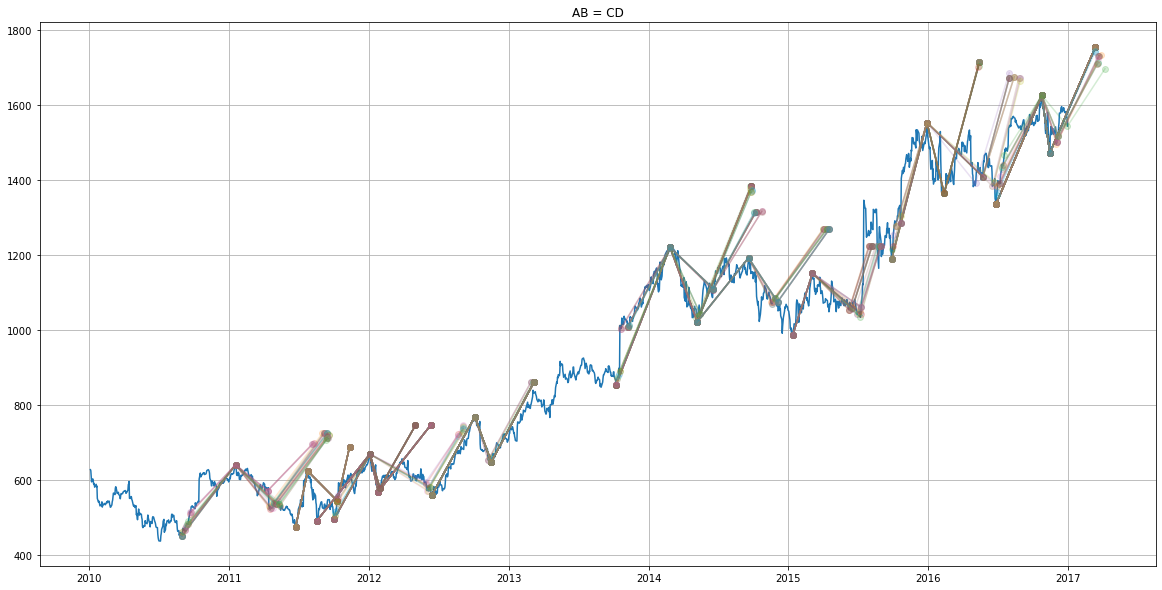

In [460]:
# plot prices, high and low
plt.figure(figsize=(20, 10))
plt.title("AB = CD")
plt.plot(stocks.close)
plt.grid()

for o in output:
    df_avg = (o['d'][1][0] + o['d'][1][1])/2
    plt.plot([o['a'][0], o['b'][0], o['c'][0], o['d'][0]], [o['a'][1], o['b'][1], o['c'][1], df_avg], marker="o", alpha=0.2, label="abc")

plt.show()

### Get derivative of the signal
* smooth signal (rolling mean)
* get derivative, to get slope of the patterns

In [461]:
# smooth signal
window = 50
stocks['close_ma'] = stocks.close.rolling(window=window, center=True).mean()

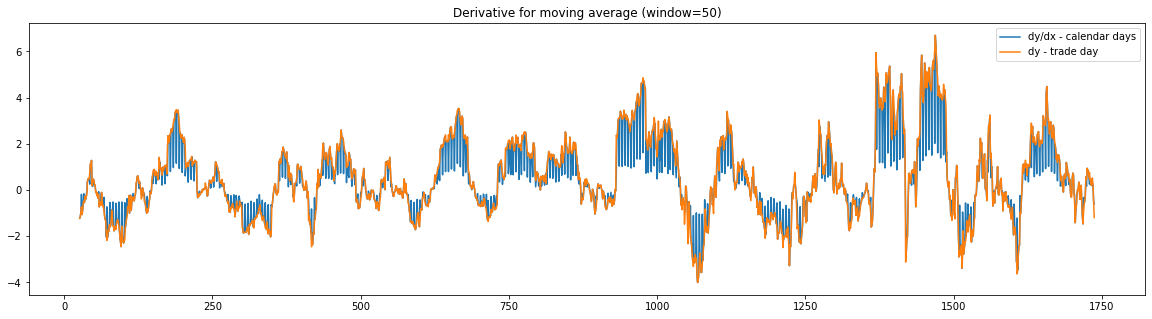

In [462]:
# calculate derivative for the moving average
dy = stocks.close_ma.diff(1)
dx = stocks.reset_index().date.diff(1).dt.days.fillna(0).astype(int)

# use derivative and correct for different time intervals (ie. for missing days)
derivative_day = dy.values / dx.values

# use derivative for trade days. Requires that data for all trade days is available. 
derivative_trade_day = dy.values

plt.figure(figsize=(20, 5))
plt.title(f"Derivative for moving average (window={window})")
plt.plot(derivative_day, label="dy/dx - calendar days")
plt.plot(derivative_trade_day, label="dy - trade day")
plt.legend()
plt.show()

In [463]:
# take derivative for trade days with a window of 10
window_close = 10
stocks['close_ma'] = stocks.close.rolling(window=window_close, center=True).mean()

# calculate derivative for the moving average
dy = stocks.close_ma.diff(1)
dx = stocks.reset_index().date.diff(1).dt.days.fillna(0).astype(int)

# use derivative for trade days. Requires that data for all trade days is available. 
derivative_trade_day = dy.values

stocks['derivative'] = derivative_trade_day

window_derivative = 10
stocks['derivative_ma'] = stocks.derivative.rolling(window=window_derivative, center=True).mean()

When calculating the derivative as dy/dx it does take the time interval into account. This is not the best way, of the weekends. Friday and Monday are subsequent trade days, and it does not make sence to take the weekend into account for the derivative

So, derivative is taken for trade days. This requires that records for all trade days are present, as there will be no correction for missing data any more.

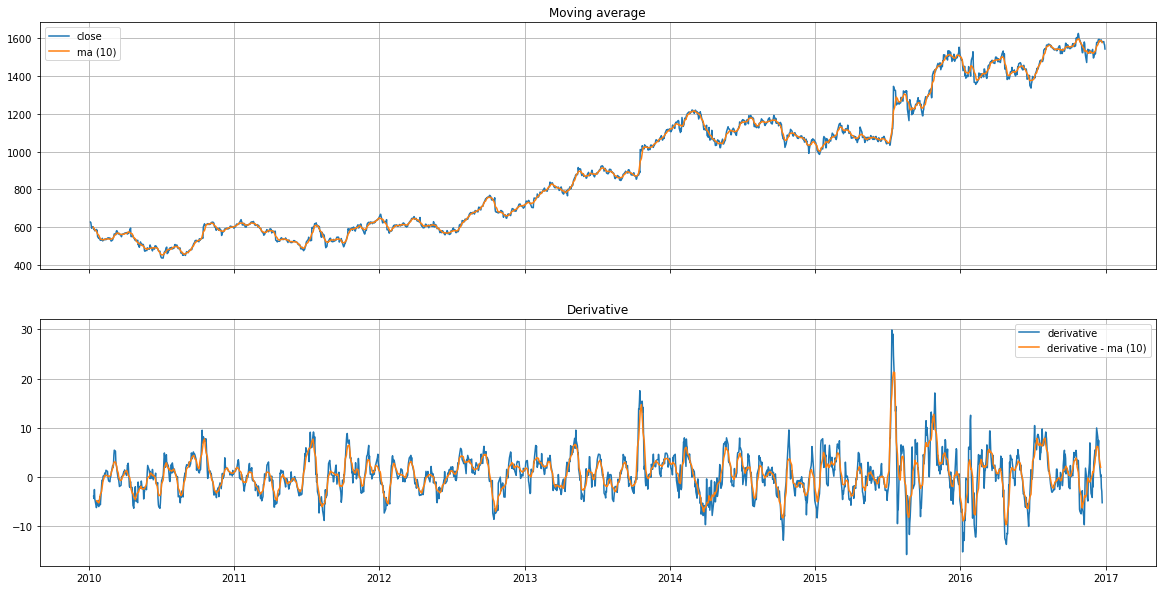

In [464]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

axs[0].set_title("Moving average")
axs[0].plot(stocks.close, label="close")
axs[0].plot(stocks['close_ma'], label=f"ma ({window_close})")
axs[0].grid(True)
axs[0].legend()

axs[1].set_title("Derivative")
axs[1].plot(stocks['derivative'], label="derivative")
axs[1].plot(stocks['derivative_ma'], label=f"derivative - ma ({window_derivative})")
axs[1].grid(True)
axs[1].legend()

plt.show()

### Zero crossings

In [465]:
def zero_crossings(x, y, direction=None):
    """
    Return indices of points right *before* a zero-crossing, find subsequent points where product is negative

    :param x: DatetimeIndex
    :param y: Numpy array (use .values when using Series)
    :param direction: {'asc', 'desc'}, determines which zerocrossing to return (ascending, or descening)

    :return: DatetimeIndex with the zerocrossings
    """

    if direction == "asc":
        indi = np.where((y[1:]*y[0:-1] < 0.0) &
                        (np.abs(y[1:])*y[0:-1] < 0.0))[0]
    elif direction == "desc":
        indi = np.where((y[1:]*y[0:-1] < 0.0) &
                        (np.abs(y[1:])*y[0:-1] >= 0.0))[0]
    else:
        indi = np.where(y[1:]*y[0:-1] < 0.0)[0]

    # Find the zero crossing by linear interpolation
    dx = x[indi+1] - x[indi]
    dy = y[indi+1] - y[indi]

    return -y[indi] * (dx/dy) + x[indi]


In [466]:
x = stocks.derivative_ma.index
y = stocks.derivative_ma.values
price_change_up = zero_crossings(x, y, direction='asc')
price_change_down = zero_crossings(x, y, direction='desc')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal


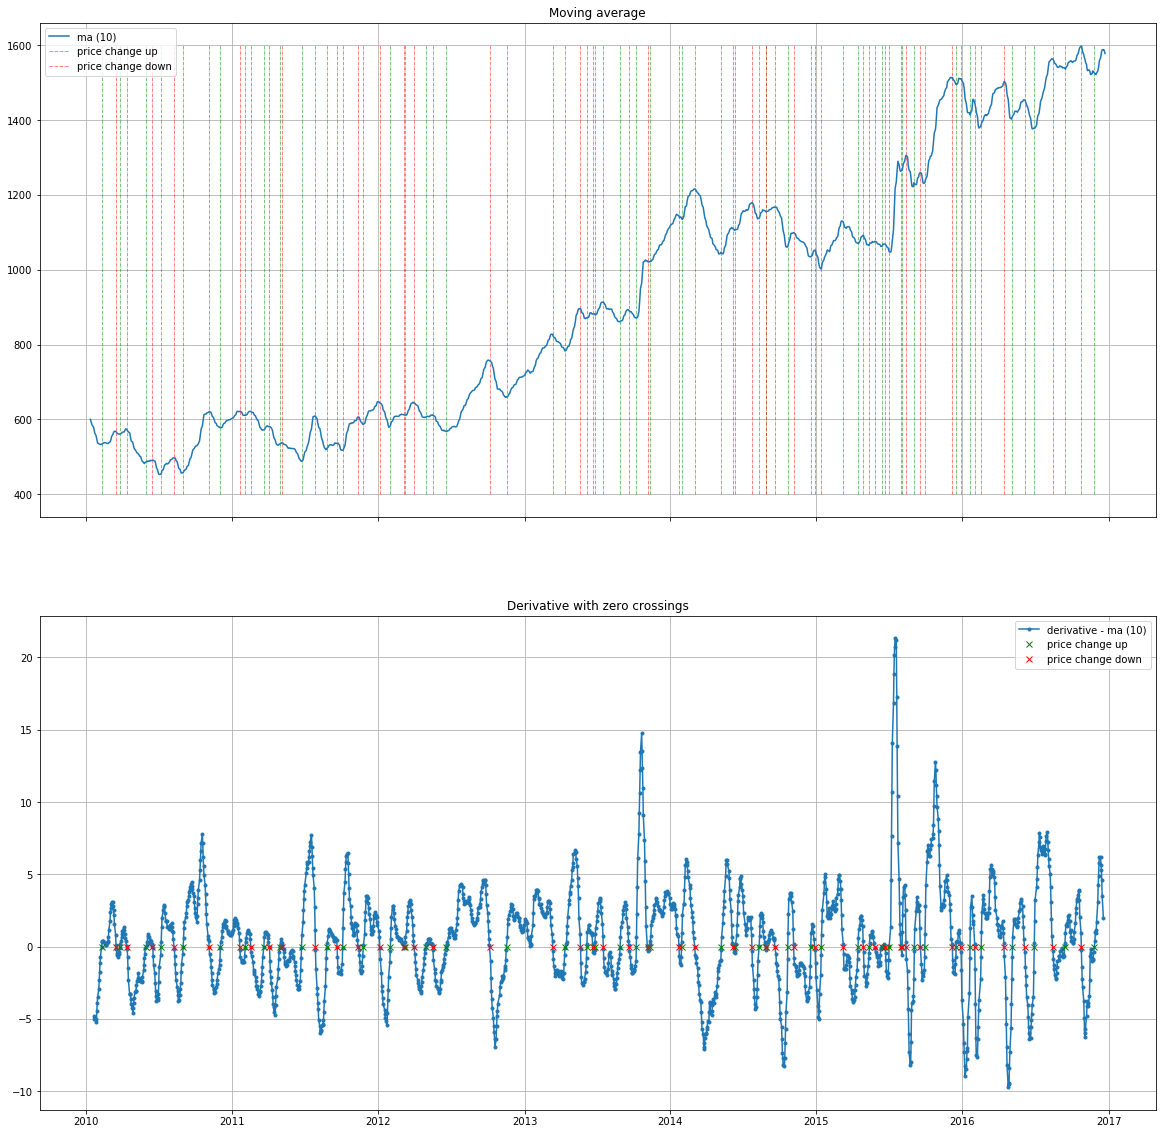

In [467]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 20), sharex=True)

axs[0].set_title("Moving average")
# axs[0].plot(stocks.close, label="close")
axs[0].plot(stocks['close_ma'], label=f"ma ({window_close})")
axs[0].vlines(price_change_up, ymin=400, ymax=1600, color="green", linewidth=0.5, linestyle="-.", label="price change up")
axs[0].vlines(price_change_down, ymin=400, ymax=1600, color="red", linewidth=0.5, linestyle="-.", label="price change down")
axs[0].grid(True)
axs[0].legend()


axs[1].set_title("Derivative with zero crossings")
#axs[1].plot(stocks['derivative'], label="derivative")
axs[1].plot(stocks['derivative_ma'], label=f"derivative - ma ({window_derivative})", marker=".")
axs[1].plot(price_change_up, [0]*len(price_change_up), marker="x", color="green", linestyle="None", label="price change up")
axs[1].plot(price_change_down, [0]*len(price_change_down), marker="x", color="red", linestyle="None", label="price change down")

axs[1].grid(True)
axs[1].legend()


plt.show()

### Next: create numeric metric to evaluate models

Before we develop models, we need a numeric metric to measure success. As a first attempt, we make a few simplifications:
- take transaction fees are not taken into account.
- single stock only
- complete amount is used
    - can only sell what you have
    - can only buy if you have amount

*approach*

- agent starts with starting amount
- input for the agent is a window of records, agent returns an order or None
- `[{'buy': (date, value), 'sell': (date, value)}, .. ]`

- success is measured as the percentage of the value difference `(sell - buy) / buy`
  - ie. if you buy at a value of 100 and sell at 120 a profit of 20% is made

### model 1: buy just before ascending zero-crossing, sell just before descending zero-crossing

In [477]:
df_window.tail()

,symbol,open,close,low,high,volume,close_ma,derivative,derivative_ma
date,,,,,,,,,
2012-11-14,GOOG,660.661134,652.551123,650.501106,662.181156,3349200.0,659.257121,-6.499992,-1.340604
2012-11-15,GOOG,650.001130,647.261096,643.901131,660.001136,3711500.0,659.132124,-5.290027,-0.933402
2012-11-16,GOOG,645.991093,647.181085,636.001073,653.021141,6902000.0,660.700128,-0.080011,-0.262501
2012-11-19,GOOG,655.701136,668.211130,655.531128,668.921119,4754100.0,660.512127,21.030045,0.651900
2012-11-20,GOOG,669.511153,669.971123,664.571127,678.001184,4192900.0,660.993123,1.759993,1.540002


In [581]:
class Simulator:
    def __init__(self, df, window_size=30, start_amount=100):
        self.agents = []
        self.df = df
        self.window_size=window_size
        self.start_amount=start_amount
        
    def add_agent(self, agent_instance):
        self.agents.append({
            'instance': agent_instance, 
            'balance': [{'date': self.df.iloc[0].name, 'amount': self.start_amount, 'assets': 0}],
            'transactions': []
        })
    
    def get_agent_orders(self):
        # loop through all records in df
        for i in np.arange(1, len(self.df)):
            # prepare window
            df_window = self.df.iloc[np.maximum(0, i-self.window_size):i, :]
            
            # get order for each agent
            for agent in self.agents:
                order_date, action, amount = agent.get('instance').get_order(df_window)
                
                if action:
                    transaction = {
                        'date': order_date,
                        'action': action,
                        'price': self.df.loc[order_date,'close'],
                        'amount': amount
                    }
                    
                    agent.get('transactions').append(transaction)
                    
                    self.update_balance(agent, transaction)
    
    
    def update_balance(self, agent, transaction):
        # buy: decrease amount, increase assets with fraction of stock
        # sell: increase amount, decrease assets with fraction of stock
        
        # get current balance
        current_balance = agent.get('balance')[-1]
            
        if transaction.get('action') == "buy":
            # spend complete amount at each transaction for now
            new_assets = current_balance.get('amount') / transaction.get('price')
            
            new_balance = {
                'date': transaction.get('date'),
                'assets': current_balance.get('assets') + new_assets,
                'amount': 0
            }
        if transaction.get('action')  == "sell":
            # sell all assets at each transaction for now
            new_amount = current_balance.get('assets') * transaction.get('price')
            
            new_balance = {
                'date': transaction.get('date'),
                'assets': 0,
                'amount': new_amount
            }
        
        agent.get('balance').append(new_balance)

In [582]:
class MyFirstAgent:
    def __init__(self, name):
        self.name = name
        
    def __repr__(self):
        return self.name
    
    def get_order(self, df_window):
        current_date = df_window.iloc[-1].name
        if current_date == datetime(2012, 11, 15):
            return (current_date, "buy", "max")
        if current_date == datetime(2012, 11, 20):
            return (current_date, "sell", "max")
        return (current_date, None, None)

In [594]:
a = datetime(2020, 1, 1)
d = {a:1}

In [596]:
d[a]

1

In [631]:
class ABCDAgent:
    def __init__(self, name):
        self.name = name
        self.date_previous_d = None
        self.orders = {}
        '''
        strategy: find ABCD patterns, buy on C, sell on D (market price, bullish market only)
        
        conditions:
        - place buy orders only on new patterns, so, date of A should be > date previous D
        
        '''
    def __repr__(self):
        return self.name
    
    def get_order(self, df_window):
        current_date = df_window.iloc[-1].name
        
        if self.date_previous_d is None:
            # initialize to first valid date in the data
            self.date_previous_d = current_date
          
        # search for ABCD and place orders if found 
        pattern = find_abcd(df_window, price_interval=(50, 500), ab_interval=(timedelta(30), timedelta(150)), bc_interval=(timedelta(10), timedelta(80)), value_range_point_c=0.1)
        if pattern:
            date_a = pattern['a'][0]
            date_c = pattern['c'][0]
            date_d = pattern['d'][0]
            # check if found pattern does not overlap with a previous found pattern
            if date_a > self.date_previous_d and date_c >= current_date:
                # schedule buy order for c, sell order for d                         
                self.orders[date_c] = (date_c, "buy", "max")
                self.orders[date_d] = (date_d, "sell", "max")
                self.date_previous_d = date_d
                
        order = self.orders.get(current_date, False)
        if order:
            print("order found:", order)
            return order
        return (current_date, None, None)
    

In [632]:
simulator = Simulator(df=stocks, window_size=150, start_amount=100)
simulator.add_agent(MyFirstAgent(name="My first agent"))
simulator.add_agent(ABCDAgent(name="ABCD Agent"))
simulator.get_agent_orders()

order found: (Timestamp('2011-04-15 00:00:00'), 'buy', 'max')
order found: (Timestamp('2011-08-19 00:00:00'), 'sell', 'max')
order found: (Timestamp('2012-05-18 00:00:00'), 'buy', 'max')
order found: (Timestamp('2012-06-27 00:00:00'), 'sell', 'max')
order found: (Timestamp('2014-05-06 00:00:00'), 'buy', 'max')
order found: (Timestamp('2014-09-24 00:00:00'), 'sell', 'max')
order found: (Timestamp('2015-05-12 00:00:00'), 'buy', 'max')
order found: (Timestamp('2016-05-17 00:00:00'), 'buy', 'max')
order found: (Timestamp('2016-07-25 00:00:00'), 'sell', 'max')


In [679]:
df_transactions = pd.DataFrame(simulator.agents[1]['transactions']).set_index('date')
df_transactions

,action,price,amount
date,,,
2011-04-15,buy,530.700938,max
2011-08-19,sell,490.920851,max
2012-05-18,buy,600.401031,max
2012-06-27,sell,569.300956,max
2014-05-06,buy,1030.284660,max
2014-09-24,sell,1175.985268,max
2015-05-12,buy,1058.079956,max
2016-05-17,buy,1412.459960,max
2016-07-25,sell,1479.540040,max


In [678]:
df_balance = pd.DataFrame(simulator.agents[1]['balance']).set_index('date')
df_balance

,amount,assets
date,,
2010-01-04,100.000000,0.000000
2011-04-15,0.000000,0.188430
2011-08-19,92.504237,0.000000
2012-05-18,0.000000,0.154071
2012-06-27,87.712625,0.000000
2014-05-06,0.000000,0.085134
2014-09-24,100.116753,0.000000
2015-05-12,0.000000,0.094621
2016-05-17,0.000000,0.094621


In [687]:
df_balance_amount = df_balance[df_balance.amount > 0]
start_amount = df_balance_amount.iloc[0].amount
end_amount = df_balance_amount.iloc[-1].amount
profit = end_amount - start_amount
profit_perc = 100 * profit / start_amount

39.99579461264338

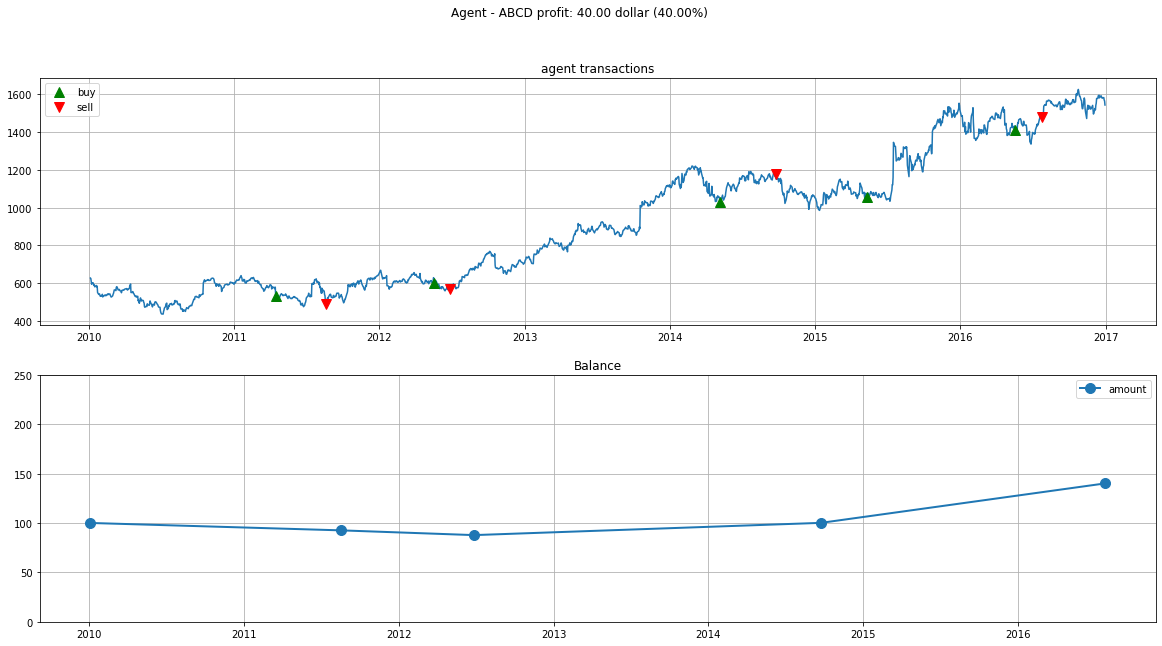

In [695]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.suptitle(f"Agent - ABCD profit: {profit:.2f} dollar ({profit_perc:.2f}%)")

axs[0].set_title("agent transactions")
axs[0].plot(stocks.close)
axs[0].plot(df_transactions[df_transactions.action == 'buy'].price, marker="^", linestyle="None", label="buy", color="green", markersize=10)
axs[0].plot(df_transactions[df_transactions.action == 'sell'].price, marker="v", linestyle="None", label="sell", color="red", markersize=10)
axs[0].legend()
axs[0].grid(True)
axs[1].legend()

axs[1].set_title("Balance")
axs[1].plot(df_balance[df_balance.amount>0].amount, label="amount", linewidth=2, marker=".", markersize=20)
axs[1].set_ylim(0, 250)
axs[1].legend()
axs[1].grid(True)

plt.show()

In [696]:
pd.DataFrame(simulator.agents[1]['transactions'])

,date,action,price,amount
0,2011-04-15,buy,530.700938,max
1,2011-08-19,sell,490.920851,max
2,2012-05-18,buy,600.401031,max
3,2012-06-27,sell,569.300956,max
4,2014-05-06,buy,1030.284660,max
5,2014-09-24,sell,1175.985268,max
6,2015-05-12,buy,1058.079956,max
7,2016-05-17,buy,1412.459960,max
8,2016-07-25,sell,1479.540040,max


In [635]:
pd.DataFrame(simulator.agents[1]['balance'])

,date,amount,assets
0,2010-01-04,100.000000,0.000000
1,2011-04-15,0.000000,0.188430
2,2011-08-19,92.504237,0.000000
3,2012-05-18,0.000000,0.154071
4,2012-06-27,87.712625,0.000000
5,2014-05-06,0.000000,0.085134
6,2014-09-24,100.116753,0.000000
7,2015-05-12,0.000000,0.094621
8,2016-05-17,0.000000,0.094621
9,2016-07-25,139.995795,0.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal


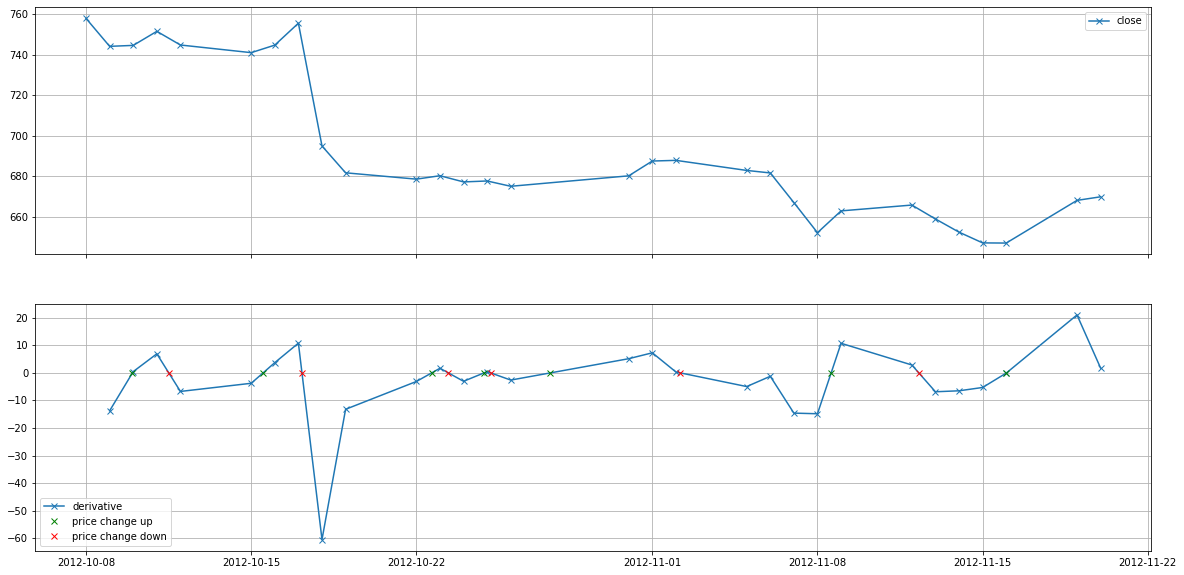

In [470]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(df_window.close, marker="x", label="close")
ax1.legend()
ax1.grid(True)

ax2.plot(df_window.derivative, marker="x", label="derivative")
ax2.plot(price_change_up, [0]*len(price_change_up), marker="x", color="green", linestyle="None", label="price change up")
ax2.plot(price_change_down, [0]*len(price_change_down), marker="x", color="red", linestyle="None", label="price change down")
ax2.legend()
ax2.grid(True)